In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.layers import Input,Dense, Dropout
from tensorflow.keras import Model
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer,TFBertModel
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from prettytable import PrettyTable
from tensorflow.keras.initializers import GlorotNormal

In [ ]:
# Importing the data

# train_df=pd.read_csv('../input/natural-language-processing-with-disaster-tweets/kaggle nlp/train.csv')
# test_df=pd.read_csv('../input/natural-language-processing-with-disaster-tweets/kaggle nlp/test.csv')

In [4]:
# # importing the data

train_df=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')

In [10]:
train_df=train_df[['text','target']].dropna()
train_df=train_df.sample(frac=1)

X_train=train_df['text']
y_train=train_df['target']
X_test=test_df['text']

print(X_train.shape, y_train.shape)
print(X_test.shape)

(7613,) (7613,)
(3263,)


## 1) Main Functions

In [12]:
def lowercase(text):
    return text.lower()

# 2 Decontracting the text
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"\'cause", " because", phrase)
    phrase = re.sub(r"let\'s", "let us", phrase)
    return phrase

# 3 Removing URLs
def remove_url(text):
    text= re.sub(r'https?://\S+|www\.\S+', '', text)
    return text

# 4 Removing HTMLs
def remove_html(text):
    text=re.sub(r'<.*?>','',text)
    return text


In [13]:
# 5 Removing Slangs or chat words
# Converting slangs and chat words like BRB to Be Right Back, FYI to For Your Information
slangs="""AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The A..
PRT=Party
PRW=Parents Are Watching
QPSA=Que Pasa?
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My A.. Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The F...
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait...
7K=Sick:-D Laugher
IG=Instagram
FB=Facebook
PPL=People
R=Are
PC=Computer"""

# Making the dictionary of the above strings
pattern=re.compile('\\n')
slangs=pattern.sub(r'  ',slangs)
slangs_dict={}
for i in slangs.split('  '):
    lst=i.split('=')
    slangs_dict[lst[0]]=lst[1]

def remove_slangs(text):
    new_text=[]
    for word in text.split():
        if word.upper() in slangs_dict:
            new_text.append(slangs_dict[word.upper()].lower())
        else:
            new_text.append(word)
    return ' '.join(new_text)


In [14]:
def basic_preprocessing(text):
    
    text=lowercase(text)           # 1
    text=decontracted(text)        # 2    
    text=remove_url(text)          # 3
    text=remove_html(text)         # 4
    text=remove_slangs(text)       # 5
    
    return text

In [50]:
def performance_evaluation(y_actual, y_pred):
    
    """This function prints the confusion matrix and all the other evalutaion metrics like Precision, Recall and F1 Score"""
    
    
    # Plotting Confusion Matrix
    c_test=confusion_matrix(y_actual,y_pred)

    plt.figure(figsize=(6,6))
    sns.heatmap(c_test/np.sum(c_test),annot=True,fmt='.2%',cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("Confusion Matrix")
    plt.show()
    

    tn,fp,fn,tp=c_test.ravel()
    # print(classification_report(y_test,y_test_pred_value))
    print()
    
    table=PrettyTable(['Metrics','Values'])
    table.add_row(['Specificity(%)',np.round((tn/(tn+fp))*100,2)])
    table.add_row(['Sensitivity/Recall(%)',np.round((tp/(tp+fn))*100,2)])
    table.add_row(['Precision(%)',np.round((tp/(tp+fp))*100,2)])
    table.add_row(['Micro F1 Score',np.round(f1_score(y_actual,y_pred,average='micro'),2)])
    model_metrics=[np.round((tn/(tn+fp))*100,2),np.round((tp/(tp+fn))*100,2),np.round((tp/(tp+fp))*100,2),np.round(f1_score(y_actual,y_pred,average='micro'),2)]
    print(table)

    return model_metrics
   

In [16]:
def text_encoding(tokenizer, texts, max_length):
    
    """This function return the text embeddings after tokenization and padding the text."""
    batch_size=256
    input_ids = []
    attention_mask = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(batch,
                                             max_length=max_length, padding='max_length',
                                             truncation=True, return_attention_mask=True,
                                             return_token_type_ids=False)
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])
    
    
    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)

In [17]:
def model_architecture(bert_model, max_len):
    # Model architecture

    weight_initializer = GlorotNormal(seed=42)

    # DistilBERT Layers
    input_ids_layer = Input(shape=(max_len,), name='input_ids', dtype='int32')
    input_attention_layer = Input(shape=(max_len,), name='input_attention', dtype='int32')
    last_hidden_state = bert_model(input_ids_layer,input_attention_layer)[1]
#     cls_token = last_hidden_state[:, 0, :]

    # NN layer
    X = Dropout(0.2)(last_hidden_state)
    X = Dense(128, activation='relu')(X)
    X = Dropout(0.3)(X)
    X = Dense(64, activation='relu')(X)
    X = Dropout(0.3)(X)
    X = Dense(16, activation='relu')(X)
    
    output = Dense(1,activation='sigmoid',kernel_initializer=weight_initializer)(X)

    model_bert = Model(inputs=[input_ids_layer, input_attention_layer], outputs=output)
    
    return model_bert

In [29]:
def model_params(max_len):
    model_bert=model_architecture(bert_model, max_len)
    model_bert.load_weights('../input/sc2bert-weights/bert_weights.h5')
    
    return model_bert

## 2) Final Functions

In [19]:
# Loading BERT tokenizer and Model

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


## Function 1

In [39]:
def function_1(X):

    max_len=64
    model_bert = model_params(max_len)

    # 1 Preprocessing the text
    if type(X)==str:
        text=basic_preprocessing(X)
        text_list=[]
        text_list.append(text)
    else:
        text_list=X.apply(basic_preprocessing)

    # 2 Encoding the text data
    text_ids, text_attention=text_encoding(bert_tokenizer, text_list, max_len)

    # Modeling 
    pred_proba=model_bert.predict([text_ids, text_attention])
    prediction= np.where(pred_proba>0.5, 1, 0)

    return prediction

In [48]:
# Predicting single text
text1=X_test[0]
print(text1)
print(function_1(text1))

Just happened a terrible car crash
[[1]]


In [49]:
# Predicting multiple text inputs
text2=X_test[5:10]
print(text2)
print()
print('======Predictions==========')
print(function_1(text2))

5                   We're shaking...It's an earthquake
6    They'd probably still show more life than Arse...
7                                    Hey! How are you?
8                                     What a nice hat?
9                                            Fuck off!
Name: text, dtype: object

======Predictions==========
[[1]
 [0]
 [0]
 [0]
 [0]]


## Function 2

In [52]:
def function_2(X,y):

    max_len=64
    model_bert = model_params(max_len)

    # 1 Preprocessing the text
    text_list=X.apply(basic_preprocessing)
   
    # 2 Encoding the text data
    text_ids, text_attention=text_encoding(bert_tokenizer, text_list, max_len)

    # Modeling 
    pred_proba=model_bert.predict([text_ids, text_attention])
    prediction= np.where(pred_proba>0.5, 1, 0)
    
    model_matrices= performance_evaluation(y,prediction)

    return prediction

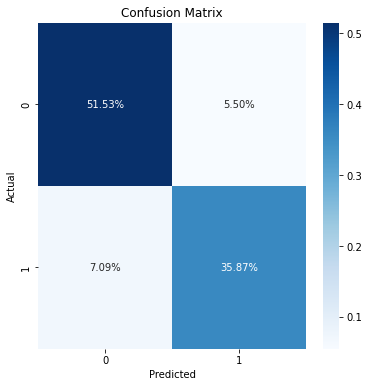


+-----------------------+--------+
|        Metrics        | Values |
+-----------------------+--------+
|     Specificity(%)    | 90.35  |
| Sensitivity/Recall(%) | 83.49  |
|      Precision(%)     |  86.7  |
|     Micro F1 Score    |  0.87  |
+-----------------------+--------+


array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [53]:
function_2(X_train,y_train)